# Run dimensionality reduction
Running this notebook will:
- load processed data from pickle files
- run dimensionality reduction on it
- show plots of results and save them to files

## Setup

### Imports and loading general params for session 

In [2]:
# General imports
import numpy as np
import numpy.linalg as la
import sys, os 
import time, datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# For responsive plot
%matplotlib widget

# Import shared modules
gen_fn_dir = os.path.abspath('.') + '/shared_scripts'
sys.path.append(gen_fn_dir)
import general_file_fns as gff
from binned_spikes_class import spike_counts
from dim_red_fns import run_dim_red

# Get current date
curr_date = datetime.datetime.now().strftime('%Y_%m_%d')+'_'

# Load and print general params and create directory to load dimensionality reduction results if needed
gen_params = gff.load_pickle_file('./general_params/general_params.pkl')
print(f"General params used for this session:\n{gen_params}")

# Create directories for saving results
dim_red_dir = gff.return_dir(gen_params['results_dir'] + 'dim_red/')
plot_path = gff.return_dir(f"./figures/")

Reading data from ./general_params/general_params.pkl...
General params used for this session:
{'raw_data_dir': './data/raw_data/', 'processed_data_dir': './data/processed/', 'kernel_rates_dir': './data/analyses/kernel_rates/', 'results_dir': './data/analyses/', 'cols': {'REM': (0.392, 0.549, 0.0784), 'SWS': (0.824, 0.627, 0.0392), 'Wake': (0.0118, 0.235, 0.392), 'measured': (0.3, 0.3, 0.3), 'fit': (0.49, 0.961, 0.961)}}


### Choose parameters

In [3]:
session = 'Mouse28-140313'
fit_dim = 3
nKnots = 15
knot_order = 'wt_per_len'
penalty_type = 'mult_len'
nTests = 10
train_frac = 0.8
area = 'ADn'    # Anatomical region to use
state = 'Wake'  # Sleep stage to use
dt_kernel = 0.1 # Kernel time step(?)
sigma = 0.1     # Kernel width
method = 'iso'  # Dimensionality reduction method, `iso` stands for isomap
n_neighbors = 5 # Number of neighbors for isomap
rate_params = {'dt' : dt_kernel, 'sigma' : sigma}
dim_red_params = {'n_neighbors' : n_neighbors, 'target_dim' : fit_dim}
desired_nSamples = 15000

print(('Session: %s, fit dim: %d, nKnots: %d, knot_order: %s, penalty: %s, nTests: %d, train_frac: %.2f'%(
    session, fit_dim, nKnots, knot_order, penalty_type, nTests, train_frac)))

Session: Mouse28-140313, fit dim: 3, nKnots: 15, knot_order: wt_per_len, penalty: mult_len, nTests: 10, train_frac: 0.80


## Project points using selected method (Isomap)

### Run dimensionality reduction

In [4]:
# Get counts from spike_counts interface
session_rates = spike_counts(session, rate_params, count_type='rate', anat_region=area) # for ADn there are 21 cell ids
counts, tmp_angles = session_rates.get_spike_matrix(state)
selected_counts = counts[:desired_nSamples]

# Run dimensionality reduction and save projected points for later
start = time.time()
projection = run_dim_red(selected_counts, params = dim_red_params, method = method)
stop = time.time()
np.save(dim_red_dir + f"{session}_{state}_{method}_{dim_red_params['target_dim']}_projection_{curr_date}.pkl", projection)
assert projection.shape == (desired_nSamples, fit_dim)
print(f"Dimensionality reduction took {stop-start:.2f} seconds.")
print(f"Shape of projected points: {projection.shape}")

Loading spike counts from ./data/analyses/kernel_rates/100ms_sigma/Mouse28-140313.pkl...
Reading data from ./general_params/area_shank_info.pkl...
Dimensionality reduction took 122.12 seconds.


### 3d plot of projection - first 3 dimensions

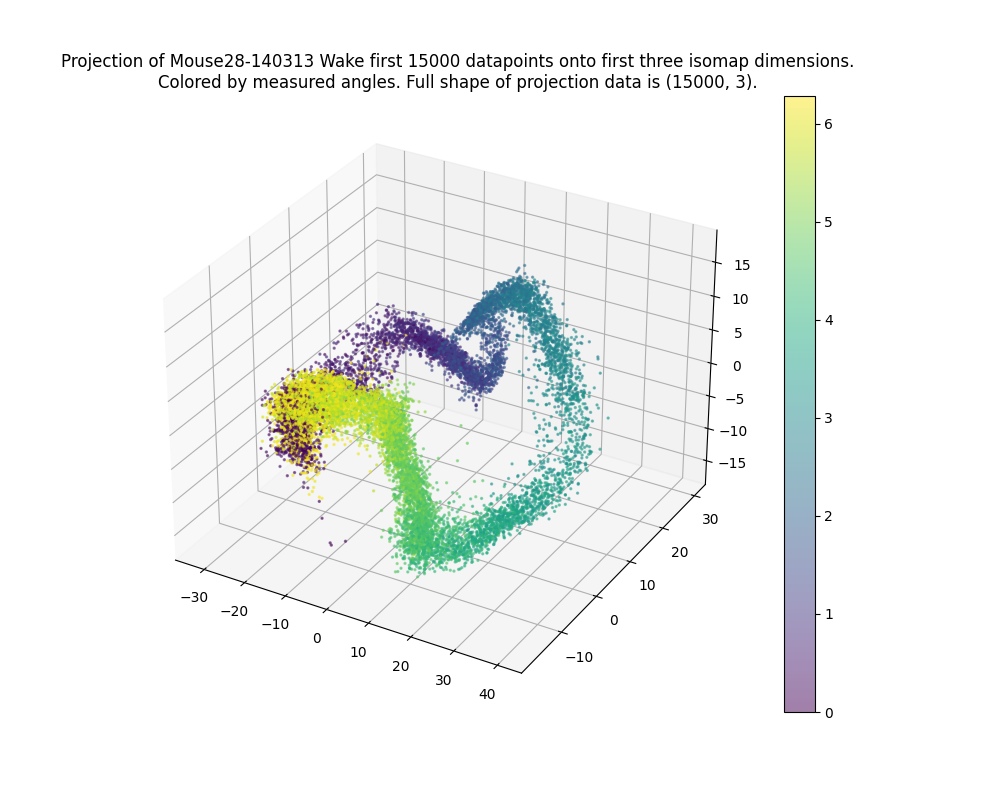

In [13]:
if fit_dim == 3:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(projection[:, 0], projection[:, 1], projection[:, 2], alpha=0.5, s = 2, c = tmp_angles[:desired_nSamples])
    ax.set_title(f'''
        Projection of {session} {state} first {desired_nSamples} datapoints onto first three isomap dimensions.
        Colored by measured angles. Full shape of projection data is {projection.shape}.''')
    plot_filename = plot_path + f"{session}_{state}_{method}_{dim_red_params['target_dim']}_projection_{curr_date}.png"
    plt.colorbar(sc)
    plt.savefig(plot_filename)
    plt.show()